# 6DoF Pose Estimation with Ultrasound Frames and IMU Data


## 1. Import Libraries


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import yaml
from scipy.spatial.transform import Rotation
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm.notebook import tqdm

## 2. Load and Preprocess Data


In [2]:
def load_data(file_path):
    return pd.read_hdf(file_path)


file_path = "scans/20240826/wrist_data.h5"
df = load_data(file_path)

In [3]:
df.head()

,timestamp,frame,imu_acc_x,imu_acc_y,imu_acc_z,imu_orientation_x,imu_orientation_y,imu_orientation_z,ot_pos_x,ot_pos_y,ot_pos_z,ot_qw,ot_qx,ot_qy,ot_qz
0,2024-08-14 14:04:53.612948,"[[[35, 38, 38], [41, 44, 44], [54, 57, 57], [5...",0.00518,-0.002743,-0.098182,-0.034068,0.040456,0.043649,108.045212,28.900089,-969.858948,0.719787,0.255863,-0.57866,0.285646
1,2024-08-14 14:04:53.712948,"[[[35, 38, 38], [41, 44, 44], [54, 57, 57], [5...",0.00518,-0.002743,-0.098182,-0.034068,0.040456,0.043649,108.045212,28.900089,-969.858948,0.719787,0.255863,-0.57866,0.285646
2,2024-08-14 14:04:53.812948,"[[[35, 38, 38], [41, 44, 44], [54, 57, 57], [5...",0.00518,-0.002743,-0.098182,-0.034068,0.040456,0.043649,108.045212,28.900089,-969.858948,0.719787,0.255863,-0.57866,0.285646
3,2024-08-14 14:04:53.912948,"[[[41, 44, 44], [49, 52, 52], [61, 64, 64], [6...",0.00518,-0.002743,-0.098182,-0.034068,0.040456,0.043649,108.045212,28.900089,-969.858948,0.719787,0.255863,-0.57866,0.285646
4,2024-08-14 14:04:54.012948,"[[[42, 45, 45], [49, 52, 52], [61, 64, 64], [6...",0.00518,-0.002743,-0.098182,-0.034068,0.040456,0.043649,108.045212,28.900089,-969.858948,0.719787,0.255863,-0.57866,0.285646


In [4]:
columns = [
    "timestamp",
    "frame",
    "imu_acc_x",
    "imu_acc_y",
    "imu_acc_z",
    "imu_orientation_x",
    "imu_orientation_y",
    "imu_orientation_z",
    "ot_pos_x",
    "ot_pos_y",
    "ot_pos_z",
    "ot_qw",
    "ot_qx",
    "ot_qy",
    "ot_qz",
]

numeric_columns = [
    "imu_acc_x",
    "imu_acc_y",
    "imu_acc_z",
    "imu_orientation_x",
    "imu_orientation_y",
    "imu_orientation_z",
    "ot_pos_x",
    "ot_pos_y",
    "ot_pos_z",
    "ot_qw",
    "ot_qx",
    "ot_qy",
    "ot_qz",
]

# convert object columns to numeric
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors="raise")

## 3. Create Dataset for 6DoF Pose Estimation


In [5]:
class PoseEstimationDatasetDisplacement(Dataset):
    def __init__(self, df, transform=None, downsample_factor=3):
        self.df = df
        self.transform = transform
        self.downsample_factor = downsample_factor

    def __len__(self):
        return (
            len(self.df) - 1
        )  # Return one less since we are calculating displacements

    def __getitem__(self, idx):
        row1 = self.df.iloc[idx]
        row2 = self.df.iloc[idx + 1]

        # Load and process ultrasound frames
        frame1 = torch.tensor(np.stack(row1["frame"])).float().permute(2, 0, 1)
        frame2 = torch.tensor(np.stack(row2["frame"])).float().permute(2, 0, 1)

        if self.downsample_factor > 1:
            frame1 = F.resize(
                frame1,
                [
                    frame1.shape[1] // self.downsample_factor,
                    frame1.shape[2] // self.downsample_factor,
                ],
            )
            frame2 = F.resize(
                frame2,
                [
                    frame2.shape[1] // self.downsample_factor,
                    frame2.shape[2] // self.downsample_factor,
                ],
            )

        # Stack frames along the channel dimension
        frames = torch.cat([frame1, frame2], dim=0)

        # IMU data from the second frame
        imu_data = torch.tensor(
            [
                row2["imu_acc_x"],
                row2["imu_acc_y"],
                row2["imu_acc_z"],
                row2["imu_orientation_x"],
                row2["imu_orientation_y"],
                row2["imu_orientation_z"],
            ]
        ).float()

        # Displacement (translation difference)
        delta_translation = torch.tensor(
            [
                row2["ot_pos_x"] - row1["ot_pos_x"],
                row2["ot_pos_y"] - row1["ot_pos_y"],
                row2["ot_pos_z"] - row1["ot_pos_z"],
            ]
        ).float()

        # Angular displacement (rotation difference in quaternion)
        q1 = Rotation.from_quat(
            [row1["ot_qx"], row1["ot_qy"], row1["ot_qz"], row1["ot_qw"]]
        )
        q2 = Rotation.from_quat(
            [row2["ot_qx"], row2["ot_qy"], row2["ot_qz"], row2["ot_qw"]]
        )
        delta_rotation = q2 * q1.inv()  # Calculate relative rotation
        delta_rotation_quat = (
            delta_rotation.as_quat()
        )  # Convert to quaternion (qx, qy, qz, qw)

        # Concatenate displacement and angular displacement
        target = torch.tensor(np.hstack((delta_translation, delta_rotation_quat)))

        return frames, imu_data, target

In [6]:
# Create the dataset
pose_dataset = PoseEstimationDatasetDisplacement(df)

# Split the dataset without random sampling
train_indices, val_indices = train_test_split(
    np.arange(len(pose_dataset)), test_size=0.2, shuffle=False
)

train_dataset = Subset(pose_dataset, train_indices)
val_dataset = Subset(pose_dataset, val_indices)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [7]:
pose_dataset[0]

(tensor([[[45.4236, 63.8781, 72.2793,  ..., 78.2692, 80.6717, 87.9683],
          [48.1371, 67.4674, 74.2905,  ..., 81.1954, 82.3264, 85.3231],
          [54.3800, 72.7009, 75.6444,  ..., 81.9592, 82.2765, 84.0203],
          ...,
          [18.2362, 24.4952, 25.3361,  ..., 26.1822, 25.5900, 24.9281],
          [18.1391, 23.7298, 24.3351,  ..., 26.7768, 25.7774, 25.1107],
          [17.8753, 23.1950, 23.6256,  ..., 26.9999, 26.3744, 26.1238]],
 
         [[48.4236, 66.8782, 75.2793,  ..., 81.2692, 83.6717, 90.9683],
          [50.7995, 70.1298, 76.9529,  ..., 83.8577, 84.9887, 87.9854],
          [54.7112, 73.0320, 75.9756,  ..., 82.2904, 82.6077, 84.3514],
          ...,
          [18.2362, 24.4952, 25.3361,  ..., 26.1822, 25.5900, 24.9281],
          [18.1391, 23.7298, 24.3351,  ..., 26.7768, 25.7774, 25.1107],
          [17.8753, 23.1950, 23.6256,  ..., 26.9999, 26.3744, 26.1238]],
 
         [[48.4236, 66.8782, 75.2793,  ..., 81.2692, 83.6717, 90.9683],
          [50.7995, 70.1298,

In [8]:
pose_dataset[0][0].shape, pose_dataset[0][1].shape, pose_dataset[0][2].shape

(torch.Size([6, 333, 219]), torch.Size([6]), torch.Size([7]))

## 4. Define Model for 6DoF Pose Estimation


In [9]:
class PoseEstimationModelDisplacement(nn.Module):
    def __init__(self, input_channels=6, downsample_factor=3):
        super(PoseEstimationModelDisplacement, self).__init__()

        # CNN for ultrasound frames
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # LSTM for IMU data (you can replace this with GRU, Mamba SSM, etc.)
        self.lstm = nn.LSTM(input_size=6, hidden_size=64, batch_first=True)

        # Fully connected layers for displacement and angular displacement
        conv_output_height = 1000 // (4 * downsample_factor)
        conv_output_width = 657 // (4 * downsample_factor)

        self.fc = nn.Sequential(
            nn.Linear(64 * conv_output_height * conv_output_width + 64, 256),
            nn.ReLU(),
            nn.Linear(
                256, 7
            ),  # 3 for displacement, 4 for angular displacement (quaternion)
        )

    def forward(self, frames, imu_data):
        # CNN for ultrasound frames
        x = self.pool(torch.relu(self.conv1(frames)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the output

        # LSTM for IMU data (or GRU, Mamba SSM, etc.)
        imu_data = imu_data.unsqueeze(1)
        if imu_data.size(0) != x.size(0):
            imu_data = imu_data.expand(x.size(0), imu_data.size(1), imu_data.size(2))

        lstm_out, _ = self.lstm(imu_data)
        lstm_out = lstm_out[:, -1, :]  # Take the last output of the sequence

        # Concatenate CNN and LSTM outputs
        combined = torch.cat((x, lstm_out), dim=1)

        # Fully connected layers for displacement and angular displacement
        output = self.fc(combined)

        return output

## 5. Train the Model


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PoseEstimationModelDisplacement().to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5, verbose=True
)

/home/varun/mambaforge/envs/abusfusion/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=1000,
    patience=10,
):
    best_val_loss = float("inf")
    best_model_weights = None
    epochs_no_improve = 0

    for epoch in tqdm(range(num_epochs), desc="Epochs", position=0):
        model.train()
        train_loss = 0.0
        epoch_progress = tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", position=1, leave=False
        )

        for frames, imu_data, targets in epoch_progress:
            frames, imu_data, targets = (
                frames.to(device),
                imu_data.to(device),
                targets.to(device),
            )
            optimizer.zero_grad()

            # Forward pass
            outputs = model(frames, imu_data)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_loss_avg = train_loss / (epoch_progress.n + 1)
            epoch_progress.set_postfix({"Avg Loss": f"{train_loss_avg:.4f}"})

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for frames, imu_data, targets in val_loader:
                frames, imu_data, targets = (
                    frames.to(device),
                    imu_data.to(device),
                    targets.to(device),
                )
                outputs = model(frames, imu_data)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        tqdm.write(
            f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss:.4f}"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                tqdm.write("Early stopping triggered")
                break

    model.load_state_dict(best_model_weights)
    return model

In [12]:
# Train the model
trained_model = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler
)

# Save the best model
torch.save(trained_model.state_dict(), "best_model.pth")

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/1000, Train Loss: 5.1260, Val Loss: 0.2180


Epoch 2/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/1000, Train Loss: 0.2318, Val Loss: 0.2124


Epoch 3/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/1000, Train Loss: 0.2037, Val Loss: 0.2096


Epoch 4/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/1000, Train Loss: 0.2005, Val Loss: 0.2068


Epoch 5/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/1000, Train Loss: 0.1973, Val Loss: 0.2041


Epoch 6/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/1000, Train Loss: 0.1946, Val Loss: 0.2020


Epoch 7/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/1000, Train Loss: 0.1922, Val Loss: 0.1999


Epoch 8/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/1000, Train Loss: 0.1897, Val Loss: 0.1977


Epoch 9/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/1000, Train Loss: 0.1873, Val Loss: 0.1956


Epoch 10/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/1000, Train Loss: 0.1812, Val Loss: 0.1935


Epoch 11/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/1000, Train Loss: 0.1830, Val Loss: 0.1923


Epoch 12/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12/1000, Train Loss: 0.1813, Val Loss: 0.1910


Epoch 13/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13/1000, Train Loss: 0.1797, Val Loss: 0.1901


Epoch 14/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14/1000, Train Loss: 0.1784, Val Loss: 0.1894


Epoch 15/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15/1000, Train Loss: 0.1775, Val Loss: 0.1888


Epoch 16/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16/1000, Train Loss: 0.1766, Val Loss: 0.1881


Epoch 17/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17/1000, Train Loss: 0.1722, Val Loss: 0.1874


Epoch 18/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18/1000, Train Loss: 0.1748, Val Loss: 0.1868


Epoch 19/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19/1000, Train Loss: 0.1705, Val Loss: 0.1862


Epoch 20/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/1000, Train Loss: 0.1730, Val Loss: 0.1855


Epoch 21/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21/1000, Train Loss: 0.1722, Val Loss: 0.1849


Epoch 22/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 22/1000, Train Loss: 0.1714, Val Loss: 0.1841


Epoch 23/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 23/1000, Train Loss: 0.1707, Val Loss: 0.1835


Epoch 24/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 24/1000, Train Loss: 0.1665, Val Loss: 0.1828


Epoch 25/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 25/1000, Train Loss: 0.1692, Val Loss: 0.1821


Epoch 26/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 26/1000, Train Loss: 0.1684, Val Loss: 0.1814


Epoch 27/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 27/1000, Train Loss: 0.1677, Val Loss: 0.1808


Epoch 28/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 28/1000, Train Loss: 0.1670, Val Loss: 0.1801


Epoch 29/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 29/1000, Train Loss: 0.1629, Val Loss: 0.1794


Epoch 30/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 30/1000, Train Loss: 0.1655, Val Loss: 0.1787


Epoch 31/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 31/1000, Train Loss: 0.1648, Val Loss: 0.1780


Epoch 32/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 32/1000, Train Loss: 0.1640, Val Loss: 0.1773


Epoch 33/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 33/1000, Train Loss: 0.1633, Val Loss: 0.1766


Epoch 34/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 34/1000, Train Loss: 0.1626, Val Loss: 0.1760


Epoch 35/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 35/1000, Train Loss: 0.1618, Val Loss: 0.1753


Epoch 36/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 36/1000, Train Loss: 0.1611, Val Loss: 0.1746


Epoch 37/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 37/1000, Train Loss: 0.1604, Val Loss: 0.1739


Epoch 38/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 38/1000, Train Loss: 0.1597, Val Loss: 0.1732


Epoch 39/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 39/1000, Train Loss: 0.1589, Val Loss: 0.1725


Epoch 40/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 40/1000, Train Loss: 0.1582, Val Loss: 0.1718


Epoch 41/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 41/1000, Train Loss: 0.1543, Val Loss: 0.1711


Epoch 42/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 42/1000, Train Loss: 0.1536, Val Loss: 0.1705


Epoch 43/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 43/1000, Train Loss: 0.1560, Val Loss: 0.1697


Epoch 44/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 44/1000, Train Loss: 0.1553, Val Loss: 0.1691


Epoch 45/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 45/1000, Train Loss: 0.1546, Val Loss: 0.1684


Epoch 46/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 46/1000, Train Loss: 0.1538, Val Loss: 0.1677


Epoch 47/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 47/1000, Train Loss: 0.1531, Val Loss: 0.1670


Epoch 48/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 48/1000, Train Loss: 0.1523, Val Loss: 0.1662


Epoch 49/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 49/1000, Train Loss: 0.1517, Val Loss: 0.1656


Epoch 50/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 50/1000, Train Loss: 0.1509, Val Loss: 0.1649


Epoch 51/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 51/1000, Train Loss: 0.1502, Val Loss: 0.1643


Epoch 52/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 52/1000, Train Loss: 0.1494, Val Loss: 0.1635


Epoch 53/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 53/1000, Train Loss: 0.1487, Val Loss: 0.1629


Epoch 54/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 54/1000, Train Loss: 0.1480, Val Loss: 0.1621


Epoch 55/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 55/1000, Train Loss: 0.1473, Val Loss: 0.1615


Epoch 56/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 56/1000, Train Loss: 0.1436, Val Loss: 0.1608


Epoch 57/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 57/1000, Train Loss: 0.1458, Val Loss: 0.1601


Epoch 58/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 58/1000, Train Loss: 0.1451, Val Loss: 0.1594


Epoch 59/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 59/1000, Train Loss: 0.1443, Val Loss: 0.1587


Epoch 60/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 60/1000, Train Loss: 0.1436, Val Loss: 0.1580


Epoch 61/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 61/1000, Train Loss: 0.1428, Val Loss: 0.1572


Epoch 62/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 62/1000, Train Loss: 0.1422, Val Loss: 0.1566


Epoch 63/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 63/1000, Train Loss: 0.1414, Val Loss: 0.1559


Epoch 64/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 64/1000, Train Loss: 0.1407, Val Loss: 0.1552


Epoch 65/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 65/1000, Train Loss: 0.1400, Val Loss: 0.1545


Epoch 66/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 66/1000, Train Loss: 0.1393, Val Loss: 0.1538


Epoch 67/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 67/1000, Train Loss: 0.1385, Val Loss: 0.1531


Epoch 68/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 68/1000, Train Loss: 0.1378, Val Loss: 0.1524


Epoch 69/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 69/1000, Train Loss: 0.1370, Val Loss: 0.1517


Epoch 70/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 70/1000, Train Loss: 0.1363, Val Loss: 0.1510


Epoch 71/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 71/1000, Train Loss: 0.1356, Val Loss: 0.1503


Epoch 72/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 72/1000, Train Loss: 0.1348, Val Loss: 0.1495


Epoch 73/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 73/1000, Train Loss: 0.1342, Val Loss: 0.1489


Epoch 74/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 74/1000, Train Loss: 0.1334, Val Loss: 0.1481


Epoch 75/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 75/1000, Train Loss: 0.1327, Val Loss: 0.1475


Epoch 76/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 76/1000, Train Loss: 0.1319, Val Loss: 0.1467


Epoch 77/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 77/1000, Train Loss: 0.1312, Val Loss: 0.1460


Epoch 78/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 78/1000, Train Loss: 0.1305, Val Loss: 0.1453


Epoch 79/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 79/1000, Train Loss: 0.1298, Val Loss: 0.1446


Epoch 80/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 80/1000, Train Loss: 0.1290, Val Loss: 0.1439


Epoch 81/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 81/1000, Train Loss: 0.1283, Val Loss: 0.1432


Epoch 82/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 82/1000, Train Loss: 0.1276, Val Loss: 0.1425


Epoch 83/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 83/1000, Train Loss: 0.1268, Val Loss: 0.1417


Epoch 84/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 84/1000, Train Loss: 0.1261, Val Loss: 0.1411


Epoch 85/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 85/1000, Train Loss: 0.1254, Val Loss: 0.1403


Epoch 86/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 86/1000, Train Loss: 0.1247, Val Loss: 0.1396


Epoch 87/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 87/1000, Train Loss: 0.1239, Val Loss: 0.1389


Epoch 88/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 88/1000, Train Loss: 0.1232, Val Loss: 0.1382


Epoch 89/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 89/1000, Train Loss: 0.1224, Val Loss: 0.1375


Epoch 90/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 90/1000, Train Loss: 0.1217, Val Loss: 0.1368


Epoch 91/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 91/1000, Train Loss: 0.1210, Val Loss: 0.1361


Epoch 92/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 92/1000, Train Loss: 0.1203, Val Loss: 0.1353


Epoch 93/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 93/1000, Train Loss: 0.1196, Val Loss: 0.1346


Epoch 94/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 94/1000, Train Loss: 0.1188, Val Loss: 0.1339


Epoch 95/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 95/1000, Train Loss: 0.1181, Val Loss: 0.1332


Epoch 96/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 96/1000, Train Loss: 0.1173, Val Loss: 0.1325


Epoch 97/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 97/1000, Train Loss: 0.1167, Val Loss: 0.1318


Epoch 98/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 98/1000, Train Loss: 0.1159, Val Loss: 0.1311


Epoch 99/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 99/1000, Train Loss: 0.1152, Val Loss: 0.1304


Epoch 100/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 100/1000, Train Loss: 0.1144, Val Loss: 0.1297


Epoch 101/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 101/1000, Train Loss: 0.1137, Val Loss: 0.1290


Epoch 102/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 102/1000, Train Loss: 0.1130, Val Loss: 0.1282


Epoch 103/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 103/1000, Train Loss: 0.1123, Val Loss: 0.1276


Epoch 104/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 104/1000, Train Loss: 0.1093, Val Loss: 0.1268


Epoch 105/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 105/1000, Train Loss: 0.1108, Val Loss: 0.1261


Epoch 106/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 106/1000, Train Loss: 0.1101, Val Loss: 0.1254


Epoch 107/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 107/1000, Train Loss: 0.1093, Val Loss: 0.1247


Epoch 108/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 108/1000, Train Loss: 0.1086, Val Loss: 0.1240


Epoch 109/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 109/1000, Train Loss: 0.1079, Val Loss: 0.1232


Epoch 110/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 110/1000, Train Loss: 0.1072, Val Loss: 0.1226


Epoch 111/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 111/1000, Train Loss: 0.1064, Val Loss: 0.1218


Epoch 112/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 112/1000, Train Loss: 0.1057, Val Loss: 0.1211


Epoch 113/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 113/1000, Train Loss: 0.1050, Val Loss: 0.1204


Epoch 114/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 114/1000, Train Loss: 0.1043, Val Loss: 0.1197


Epoch 115/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 115/1000, Train Loss: 0.1035, Val Loss: 0.1190


Epoch 116/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 116/1000, Train Loss: 0.1028, Val Loss: 0.1183


Epoch 117/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 117/1000, Train Loss: 0.1021, Val Loss: 0.1176


Epoch 118/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 118/1000, Train Loss: 0.1013, Val Loss: 0.1169


Epoch 119/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 119/1000, Train Loss: 0.1006, Val Loss: 0.1162


Epoch 120/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 120/1000, Train Loss: 0.0998, Val Loss: 0.1154


Epoch 121/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 121/1000, Train Loss: 0.0992, Val Loss: 0.1148


Epoch 122/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 122/1000, Train Loss: 0.0984, Val Loss: 0.1140


Epoch 123/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 123/1000, Train Loss: 0.0977, Val Loss: 0.1133


Epoch 124/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 124/1000, Train Loss: 0.0969, Val Loss: 0.1126


Epoch 125/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 125/1000, Train Loss: 0.0962, Val Loss: 0.1119


Epoch 126/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 126/1000, Train Loss: 0.0955, Val Loss: 0.1112


Epoch 127/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 127/1000, Train Loss: 0.0948, Val Loss: 0.1105


Epoch 128/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 128/1000, Train Loss: 0.0940, Val Loss: 0.1098


Epoch 129/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 129/1000, Train Loss: 0.0933, Val Loss: 0.1091


Epoch 130/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 130/1000, Train Loss: 0.0926, Val Loss: 0.1083


Epoch 131/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 131/1000, Train Loss: 0.0919, Val Loss: 0.1076


Epoch 132/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 132/1000, Train Loss: 0.0911, Val Loss: 0.1069


Epoch 133/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 133/1000, Train Loss: 0.0886, Val Loss: 0.1062


Epoch 134/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 134/1000, Train Loss: 0.0896, Val Loss: 0.1055


Epoch 135/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 135/1000, Train Loss: 0.0889, Val Loss: 0.1048


Epoch 136/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 136/1000, Train Loss: 0.0882, Val Loss: 0.1041


Epoch 137/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 137/1000, Train Loss: 0.0875, Val Loss: 0.1034


Epoch 138/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 138/1000, Train Loss: 0.0867, Val Loss: 0.1026


Epoch 139/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 139/1000, Train Loss: 0.0860, Val Loss: 0.1019


Epoch 140/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 140/1000, Train Loss: 0.0853, Val Loss: 0.1012


Epoch 141/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 141/1000, Train Loss: 0.0846, Val Loss: 0.1005


Epoch 142/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 142/1000, Train Loss: 0.0838, Val Loss: 0.0998


Epoch 143/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 143/1000, Train Loss: 0.0831, Val Loss: 0.0991


Epoch 144/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 144/1000, Train Loss: 0.0824, Val Loss: 0.0984


Epoch 145/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 145/1000, Train Loss: 0.0816, Val Loss: 0.0977


Epoch 146/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 146/1000, Train Loss: 0.0809, Val Loss: 0.0970


Epoch 147/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 147/1000, Train Loss: 0.0802, Val Loss: 0.0962


Epoch 148/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 148/1000, Train Loss: 0.0795, Val Loss: 0.0956


Epoch 149/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 149/1000, Train Loss: 0.0787, Val Loss: 0.0948


Epoch 150/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 150/1000, Train Loss: 0.0780, Val Loss: 0.0941


Epoch 151/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 151/1000, Train Loss: 0.0772, Val Loss: 0.0934


Epoch 152/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 152/1000, Train Loss: 0.0750, Val Loss: 0.0927


Epoch 153/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 153/1000, Train Loss: 0.0758, Val Loss: 0.0919


Epoch 154/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 154/1000, Train Loss: 0.0751, Val Loss: 0.0913


Epoch 155/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 155/1000, Train Loss: 0.0743, Val Loss: 0.0905


Epoch 156/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 156/1000, Train Loss: 0.0736, Val Loss: 0.0898


Epoch 157/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 157/1000, Train Loss: 0.0729, Val Loss: 0.0891


Epoch 158/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 158/1000, Train Loss: 0.0722, Val Loss: 0.0884


Epoch 159/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 159/1000, Train Loss: 0.0714, Val Loss: 0.0877


Epoch 160/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 160/1000, Train Loss: 0.0707, Val Loss: 0.0869


Epoch 161/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 161/1000, Train Loss: 0.0700, Val Loss: 0.0863


Epoch 162/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 162/1000, Train Loss: 0.0692, Val Loss: 0.0855


Epoch 163/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 163/1000, Train Loss: 0.0685, Val Loss: 0.0848


Epoch 164/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 164/1000, Train Loss: 0.0678, Val Loss: 0.0841


Epoch 165/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 165/1000, Train Loss: 0.0671, Val Loss: 0.0834


Epoch 166/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 166/1000, Train Loss: 0.0663, Val Loss: 0.0827


Epoch 167/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 167/1000, Train Loss: 0.0656, Val Loss: 0.0820


Epoch 168/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 168/1000, Train Loss: 0.0649, Val Loss: 0.0812


Epoch 169/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 169/1000, Train Loss: 0.0641, Val Loss: 0.0805


Epoch 170/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 170/1000, Train Loss: 0.0634, Val Loss: 0.0798


Epoch 171/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 171/1000, Train Loss: 0.0627, Val Loss: 0.0791


Epoch 172/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 172/1000, Train Loss: 0.0620, Val Loss: 0.0784


Epoch 173/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 173/1000, Train Loss: 0.0612, Val Loss: 0.0777


Epoch 174/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 174/1000, Train Loss: 0.0605, Val Loss: 0.0770


Epoch 175/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 175/1000, Train Loss: 0.0598, Val Loss: 0.0762


Epoch 176/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 176/1000, Train Loss: 0.0591, Val Loss: 0.0756


Epoch 177/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 177/1000, Train Loss: 0.0583, Val Loss: 0.0748


Epoch 178/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 178/1000, Train Loss: 0.0576, Val Loss: 0.0741


Epoch 179/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 179/1000, Train Loss: 0.0557, Val Loss: 0.0734


Epoch 180/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 180/1000, Train Loss: 0.0561, Val Loss: 0.0727


Epoch 181/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 181/1000, Train Loss: 0.0554, Val Loss: 0.0720


Epoch 182/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 182/1000, Train Loss: 0.0547, Val Loss: 0.0713


Epoch 183/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 183/1000, Train Loss: 0.0539, Val Loss: 0.0705


Epoch 184/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 184/1000, Train Loss: 0.0532, Val Loss: 0.0698


Epoch 185/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 185/1000, Train Loss: 0.0525, Val Loss: 0.0691


Epoch 186/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 186/1000, Train Loss: 0.0517, Val Loss: 0.0684


Epoch 187/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 187/1000, Train Loss: 0.0510, Val Loss: 0.0677


Epoch 188/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 188/1000, Train Loss: 0.0503, Val Loss: 0.0670


Epoch 189/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 189/1000, Train Loss: 0.0496, Val Loss: 0.0662


Epoch 190/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 190/1000, Train Loss: 0.0488, Val Loss: 0.0655


Epoch 191/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 191/1000, Train Loss: 0.0481, Val Loss: 0.0648


Epoch 192/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 192/1000, Train Loss: 0.0474, Val Loss: 0.0641


Epoch 193/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 193/1000, Train Loss: 0.0466, Val Loss: 0.0634


Epoch 194/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 194/1000, Train Loss: 0.0459, Val Loss: 0.0627


Epoch 195/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 195/1000, Train Loss: 0.0452, Val Loss: 0.0620


Epoch 196/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 196/1000, Train Loss: 0.0445, Val Loss: 0.0612


Epoch 197/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 197/1000, Train Loss: 0.0438, Val Loss: 0.0606


Epoch 198/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 198/1000, Train Loss: 0.0430, Val Loss: 0.0598


Epoch 199/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 199/1000, Train Loss: 0.0423, Val Loss: 0.0591


Epoch 200/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 200/1000, Train Loss: 0.0415, Val Loss: 0.0584


Epoch 201/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 201/1000, Train Loss: 0.0408, Val Loss: 0.0577


Epoch 202/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 202/1000, Train Loss: 0.0401, Val Loss: 0.0569


Epoch 203/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 203/1000, Train Loss: 0.0394, Val Loss: 0.0563


Epoch 204/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 204/1000, Train Loss: 0.0386, Val Loss: 0.0555


Epoch 205/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 205/1000, Train Loss: 0.0379, Val Loss: 0.0549


Epoch 206/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 206/1000, Train Loss: 0.0372, Val Loss: 0.0541


Epoch 207/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 207/1000, Train Loss: 0.0364, Val Loss: 0.0534


Epoch 208/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 208/1000, Train Loss: 0.0361, Val Loss: 0.0534


Epoch 209/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 209/1000, Train Loss: 0.0360, Val Loss: 0.0534


Epoch 210/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 210/1000, Train Loss: 0.0361, Val Loss: 0.0534


Epoch 211/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 211/1000, Train Loss: 0.0360, Val Loss: 0.0533


Epoch 212/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 212/1000, Train Loss: 0.0361, Val Loss: 0.0534


Epoch 213/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 213/1000, Train Loss: 0.0360, Val Loss: 0.0534


Epoch 214/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 214/1000, Train Loss: 0.0361, Val Loss: 0.0534


Epoch 215/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 215/1000, Train Loss: 0.0361, Val Loss: 0.0534


Epoch 216/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 216/1000, Train Loss: 0.0361, Val Loss: 0.0534


Epoch 217/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 217/1000, Train Loss: 0.0361, Val Loss: 0.0534


Epoch 218/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 218/1000, Train Loss: 0.0360, Val Loss: 0.0534


Epoch 219/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 219/1000, Train Loss: 0.0360, Val Loss: 0.0534


Epoch 220/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 220/1000, Train Loss: 0.0360, Val Loss: 0.0534


Epoch 221/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 221/1000, Train Loss: 0.0360, Val Loss: 0.0534
Early stopping triggered


## 6. Evaluate the Model


In [13]:
def evaluate_model(model, data_loader):
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for frames, imu_data, targets in data_loader:
            frames, imu_data, targets = (
                frames.to(device),
                imu_data.to(device),
                targets.to(device),
            )
            outputs = model(frames, imu_data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    all_predictions = np.concatenate(all_predictions)
    all_targets = np.concatenate(all_targets)

    return avg_loss, all_predictions, all_targets

In [14]:
# Evaluate the model
val_loss, val_predictions, val_targets = evaluate_model(trained_model, val_loader)
print(f"Validation Loss: {val_loss:.4f}")

Validation Loss: 0.0534


## 7. Visualize Predictions


In [15]:
with open("configs/default_config.yaml", "r") as file:
    config = yaml.safe_load(file)
probe_specs = config["probe_specs"]

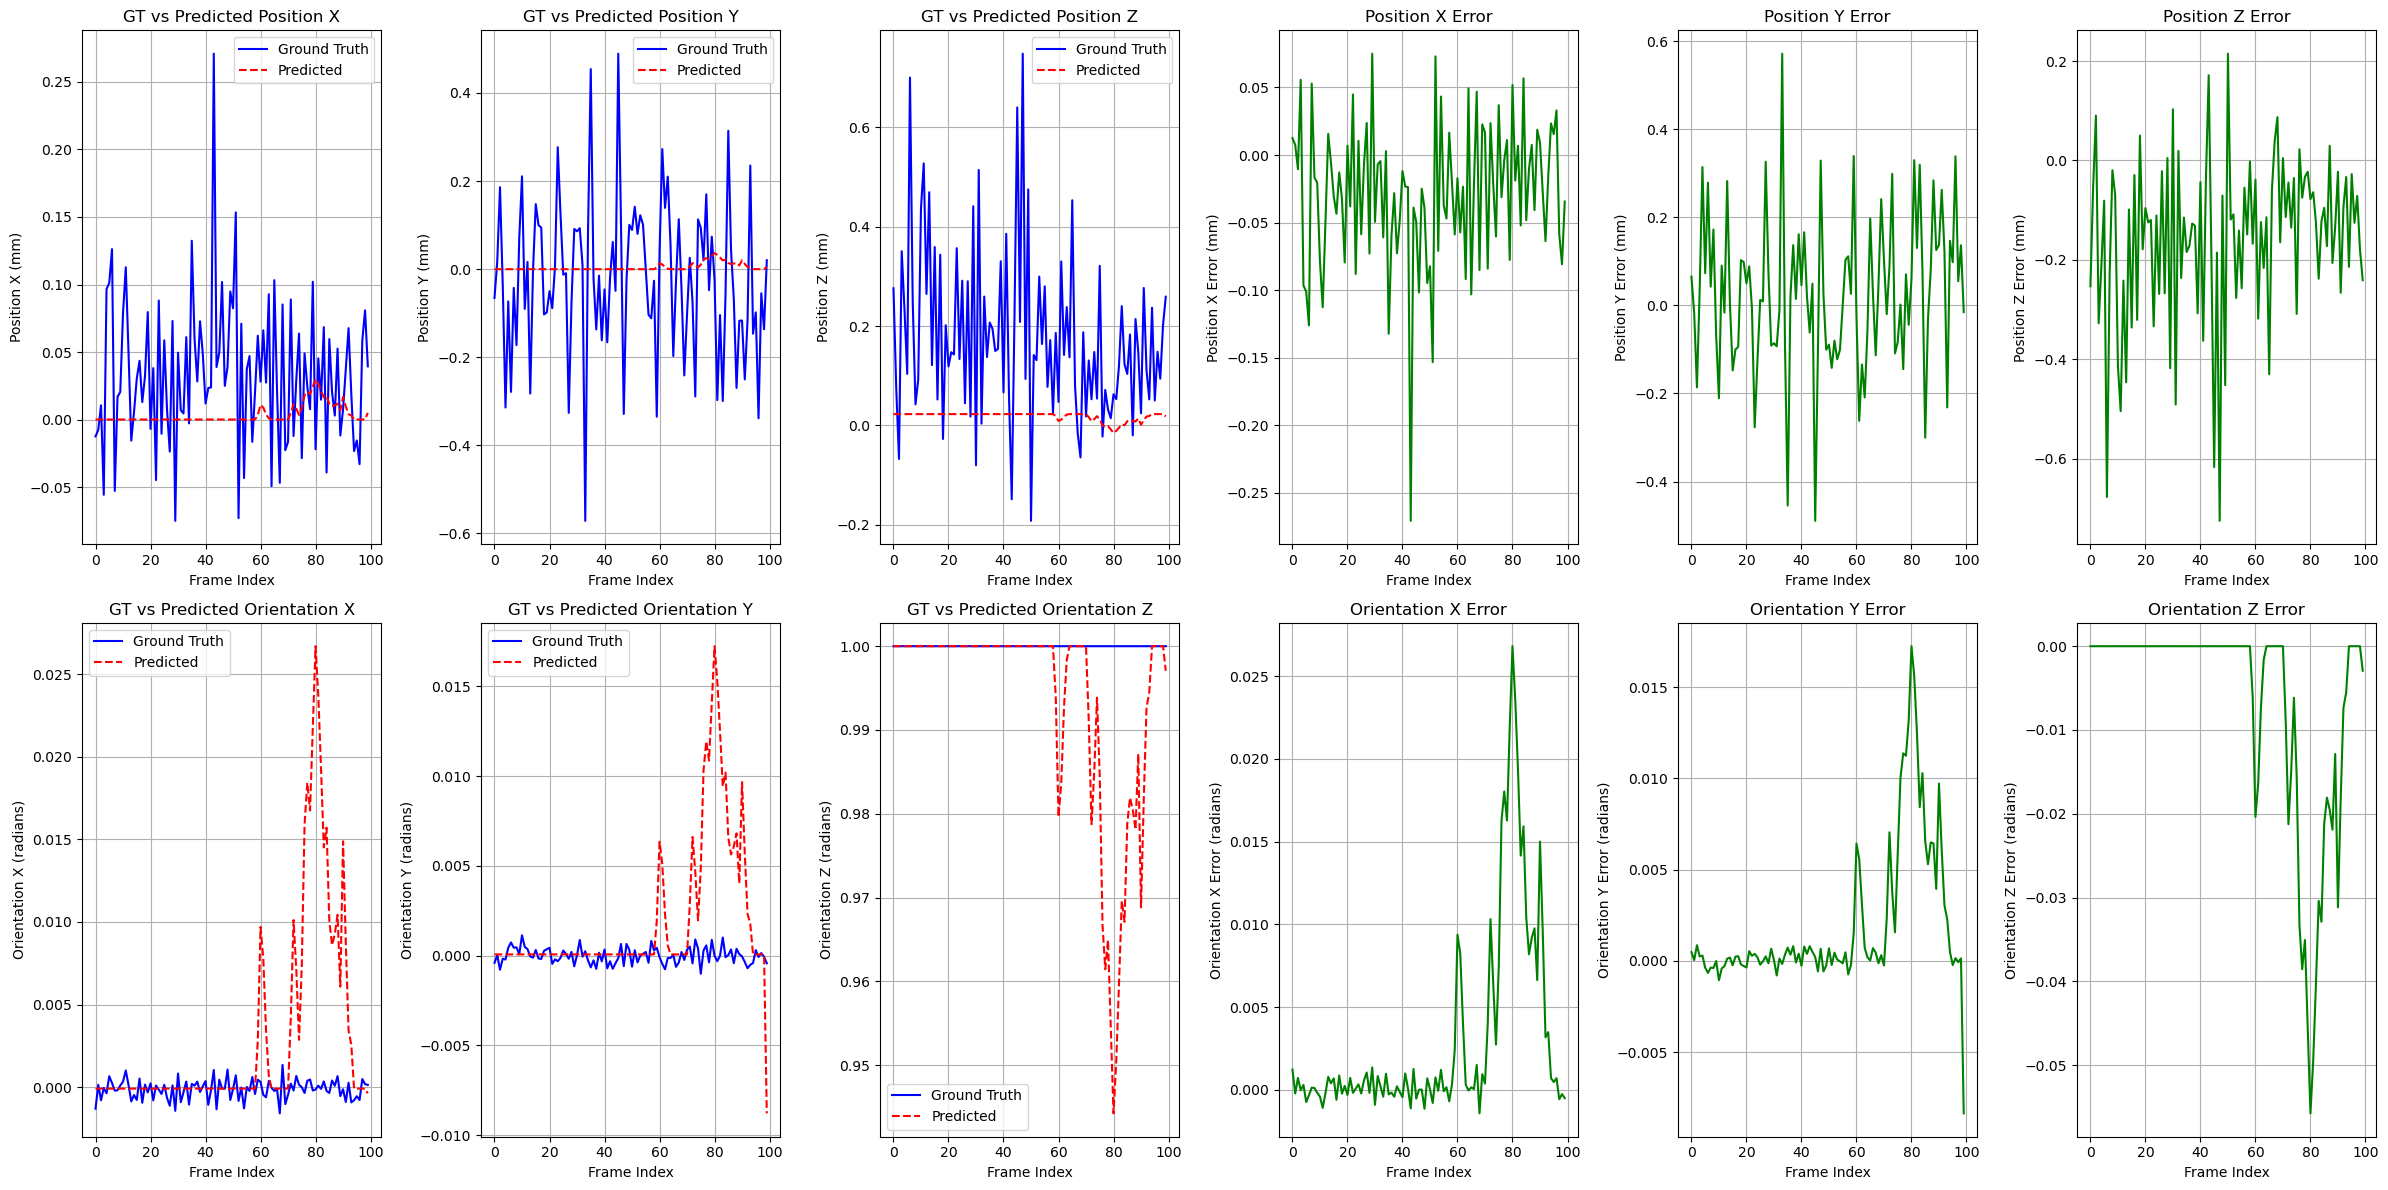

In [16]:
def plot_position_orientation_errors(predictions, targets):
    fig, axes = plt.subplots(2, 6, figsize=(24, 12))

    # Titles for position and orientation
    pos_titles = ["Position X", "Position Y", "Position Z"]
    orient_titles = ["Orientation X", "Orientation Y", "Orientation Z"]

    # Position plots (X, Y, Z)
    for i in range(3):
        # Ground Truth vs Predicted
        axes[0, i].plot(targets[:, i], label="Ground Truth", color="b")
        axes[0, i].plot(predictions[:, i], label="Predicted", color="r", linestyle="--")
        axes[0, i].set_title(f"GT vs Predicted {pos_titles[i]}")
        axes[0, i].set_xlabel("Frame Index")
        axes[0, i].set_ylabel(f"{pos_titles[i]} (mm)")
        axes[0, i].legend()
        axes[0, i].grid(True)

        # Error
        error = predictions[:, i] - targets[:, i]
        axes[0, i + 3].plot(error, label="Error", color="g")
        axes[0, i + 3].set_title(f"{pos_titles[i]} Error")
        axes[0, i + 3].set_xlabel("Frame Index")
        axes[0, i + 3].set_ylabel(f"{pos_titles[i]} Error (mm)")
        axes[0, i + 3].grid(True)

    # Orientation plots (X, Y, Z)
    for i in range(3):
        # Ground Truth vs Predicted
        axes[1, i].plot(targets[:, i + 4], label="Ground Truth", color="b")
        axes[1, i].plot(
            predictions[:, i + 4], label="Predicted", color="r", linestyle="--"
        )
        axes[1, i].set_title(f"GT vs Predicted {orient_titles[i]}")
        axes[1, i].set_xlabel("Frame Index")
        axes[1, i].set_ylabel(f"{orient_titles[i]} (radians)")
        axes[1, i].legend()
        axes[1, i].grid(True)

        # Error
        error = predictions[:, i + 4] - targets[:, i + 4]
        axes[1, i + 3].plot(error, label="Error", color="g")
        axes[1, i + 3].set_title(f"{orient_titles[i]} Error")
        axes[1, i + 3].set_xlabel("Frame Index")
        axes[1, i + 3].set_ylabel(f"{orient_titles[i]} Error (radians)")
        axes[1, i + 3].grid(True)

    plt.tight_layout()
    plt.show()


plot_position_orientation_errors(val_predictions, val_targets)

In [17]:
def reconstruct_ground_truth_volume(df, probe_specs, voxel_size=0.5):
    frames = df["frame"].values
    positions = df[["ot_pos_x", "ot_pos_y", "ot_pos_z"]].values
    orientations = df[["ot_qw", "ot_qx", "ot_qy", "ot_qz"]].values

    depth = probe_specs["depth"]
    width = probe_specs["width"]
    marker_to_probe_bottom = probe_specs["marker_to_probe_bottom"]

    axial_scale = depth / 1000
    lateral_scale = width / 657

    rotations = Rotation.from_quat(orientations[:, [1, 2, 3, 0]])

    frame_corners = np.array(
        [[0, 0, 0], [width, 0, 0], [0, depth, 0], [width, depth, 0]]
    )

    transform_matrix = np.array(
        [
            [0, 0, -1],
            [1, 0, 0],
            [0, -1, 0],
        ]
    )

    frame_corners = frame_corners @ transform_matrix.T
    frame_corners[:, 2] += marker_to_probe_bottom

    all_corners = (
        np.einsum("ijk,lk->ilj", rotations.as_matrix(), frame_corners)
        + positions[:, np.newaxis, :]
    )
    min_corner = np.min(all_corners.reshape(-1, 3), axis=0)
    max_corner = np.max(all_corners.reshape(-1, 3), axis=0)

    volume_shape = np.ceil((max_corner - min_corner) / voxel_size).astype(int) + 1
    volume = np.zeros(volume_shape, dtype=np.float32)
    counts = np.zeros(volume_shape, dtype=np.int32)

    x, y = np.meshgrid(np.arange(657) * lateral_scale, np.arange(1000) * axial_scale)
    frame_coords = np.stack((x, y, np.zeros_like(x)), axis=-1)
    frame_coords = frame_coords @ transform_matrix.T
    frame_coords[:, :, 2] += marker_to_probe_bottom

    # Lists to store frame centers and orientations
    frame_centers = []
    frame_orientations = []

    print("Reconstructing ground truth volume...")
    for i, (frame, position, orientation) in enumerate(
        tqdm(zip(frames, positions, orientations), total=len(frames))
    ):
        frame = np.mean(frame, axis=-1).astype(np.float32)

        rotation = Rotation.from_quat(orientation[[1, 2, 3, 0]]).as_matrix()
        world_coords = np.einsum("ij,klj->kli", rotation, frame_coords) + position

        voxel_coords = np.round((world_coords - min_corner) / voxel_size).astype(int)

        mask = np.all((voxel_coords >= 0) & (voxel_coords < volume_shape), axis=2)
        valid_voxels = voxel_coords[mask]
        valid_intensities = frame[mask]

        np.add.at(volume, tuple(valid_voxels.T), valid_intensities)
        np.add.at(counts, tuple(valid_voxels.T), 1)

        # Calculate frame center using corner coordinates
        frame_center = np.mean(all_corners[i], axis=0)
        frame_centers.append(frame_center)
        frame_orientations.append(orientation[[1, 2, 3, 0]])  # Reorder to [x, y, z, w]

    mask = counts > 0
    volume[mask] /= counts[mask]

    return (
        volume,
        min_corner,
        voxel_size,
        np.array(frame_centers),
        np.array(frame_orientations),
    )


# Probe specifications
probe_specs = {
    "depth": 50,  # mm (axial direction)
    "width": 38,  # mm (lateral direction, assuming 19 mm on each side of the center)
    "axial_res": 0.5,  # mm
    "lateral_res": 2,  # mm
    "slice_thickness": 5,  # mm (elevational direction)
    "marker_to_probe_bottom": 54,  # mm (approximate, to be refined)
}

# Reconstruct ground truth volume
(
    ground_truth_volume,
    volume_origin,
    voxel_size,
    ground_truth_centers,
    ground_truth_orientations,
) = reconstruct_ground_truth_volume(
    df, probe_specs, voxel_size=0.1  # lower voxel size corresponds to higher resolution
)

print(f"Ground truth volume shape: {ground_truth_volume.shape}")
print(f"Volume origin: {volume_origin}")
print(f"Voxel size: {voxel_size} mm")

# Save the ground truth volume
np.save("ground_truth_volume.npy", np.flip(ground_truth_volume, axis=0))
print("Ground truth volume saved as 'ground_truth_volume.npy'")

# Save metadata
metadata = {
    "volume_origin": volume_origin.tolist(),
    "voxel_size": voxel_size,
    "probe_specs": probe_specs,
}
np.save("ground_truth_volume_metadata.npy", metadata)
print("Metadata saved as 'ground_truth_volume_metadata.npy'")

Reconstructing ground truth volume...


  0%|          | 0/500 [00:00<?, ?it/s]

Ground truth volume shape: (697, 715, 601)
Volume origin: [  44.0769405   -13.89386663 -969.06145428]
Voxel size: 0.1 mm
Ground truth volume saved as 'ground_truth_volume.npy'
Metadata saved as 'ground_truth_volume_metadata.npy'


In [18]:
def apply_constant_rotation(rotation_matrix, axes, angle_degrees):
    """Applies a constant rotation to the specified axes."""
    angle_radians = np.deg2rad(angle_degrees)
    rotation = np.eye(3)
    if "x" in axes:
        rotation = np.dot(Rotation.from_euler("x", angle_radians).as_matrix(), rotation)
    if "y" in axes:
        rotation = np.dot(Rotation.from_euler("y", angle_radians).as_matrix(), rotation)
    if "z" in axes:
        rotation = np.dot(Rotation.from_euler("z", angle_radians).as_matrix(), rotation)
    return np.dot(rotation_matrix, rotation)

In [21]:
def reconstruct_predicted_volume_displacement(
    frames,
    predicted_displacements,
    probe_specs,
    voxel_size=0.5,
    initial_pose=None,
    ignore_orientation=False,
    rotation_axes=None,
):
    # Initialize initial pose
    if initial_pose is None:
        current_position = np.zeros(3)
        current_rotation = np.eye(3)
    else:
        current_position, current_rotation = initial_pose

    # Probe specifications
    depth = probe_specs["depth"]
    width = probe_specs["width"]
    marker_to_probe_bottom = probe_specs["marker_to_probe_bottom"]

    # Calculate scaling factors
    axial_scale = depth / frames.shape[1]
    lateral_scale = width / frames.shape[2]

    # Calculate volume bounds
    frame_corners = np.array(
        [[0, 0, 0], [width, 0, 0], [0, depth, 0], [width, depth, 0]]
    )
    transform_matrix = np.array(
        [
            [0, 0, -1],
            [1, 0, 0],
            [0, -1, 0],
        ]
    )
    frame_corners = frame_corners @ transform_matrix.T
    frame_corners[:, 2] += marker_to_probe_bottom

    all_corners = []
    positions = []

    # Set up 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")

    print("Reconstructing predicted volume...")
    for i, (frame, displacement) in enumerate(
        tqdm(zip(frames, predicted_displacements), total=len(frames))
    ):
        translation = displacement[:3]
        quaternion = displacement[3:]
        rotation_matrix = Rotation.from_quat(quaternion).as_matrix()

        # Update current position and rotation based on predicted displacement
        current_position += current_rotation @ translation
        current_rotation = current_rotation @ rotation_matrix

        # Calculate and store frame corners in world space
        corners_world = (
            np.einsum("ij,kj->ki", current_rotation, frame_corners) + current_position
        )
        all_corners.append(corners_world)

        # Store positions for sanity check
        positions.append(current_position.copy())

        # Sanity check: print displacement and rotation
        print(f"Frame {i+1}:")
        print(f"  Displacement (mm): {translation}")
        print(
            f"  Rotation (degrees): {Rotation.from_quat(quaternion).as_euler('xyz', degrees=True)}"
        )
        print(f"  Current Position (mm): {current_position}\n")

        # Sanity check: plot current position and frame corners
        for corner in corners_world:
            ax.scatter(
                corner[0],
                corner[1],
                corner[2],
                color="red",
                marker="x",
                label="Frame Corner" if i == 0 else "",
            )

    # Plot rectangles for the initial and final frames
    for j, corners in enumerate([all_corners[0], all_corners[-1]]):
        if j == 0:
            label = "Initial Frame"
            color = "blue"
        else:
            label = "Final Frame"
            color = "green"

        # Draw rectangle by connecting the corners
        ax.plot(
            [corners[0][0], corners[1][0]],
            [corners[0][1], corners[1][1]],
            [corners[0][2], corners[1][2]],
            color=color,
            label=label if j == 0 else "",
        )
        ax.plot(
            [corners[1][0], corners[3][0]],
            [corners[1][1], corners[3][1]],
            [corners[1][2], corners[3][2]],
            color=color,
        )
        ax.plot(
            [corners[3][0], corners[2][0]],
            [corners[3][1], corners[2][1]],
            [corners[3][2], corners[2][2]],
            color=color,
        )
        ax.plot(
            [corners[2][0], corners[0][0]],
            [corners[2][1], corners[0][1]],
            [corners[2][2], corners[0][2]],
            color=color,
        )

    all_corners = np.array(all_corners)
    min_corner = np.min(all_corners.reshape(-1, 3), axis=0)
    max_corner = np.max(all_corners.reshape(-1, 3), axis=0)

    # Initialize volume
    volume_shape = np.ceil((max_corner - min_corner) / voxel_size).astype(int) + 1
    volume = np.zeros(volume_shape, dtype=np.float32)
    counts = np.zeros(volume_shape, dtype=np.int32)

    # Create coordinate grid for frames
    x, y = np.meshgrid(
        np.arange(frames.shape[2]) * lateral_scale,
        np.arange(frames.shape[1]) * axial_scale,
    )
    frame_coords = np.stack((x, y, np.zeros_like(x)), axis=-1)
    frame_coords = frame_coords @ transform_matrix.T
    frame_coords[:, :, 2] += marker_to_probe_bottom

    for i, frame in enumerate(tqdm(frames, total=len(frames))):
        if frame.ndim == 3:
            frame = np.mean(frame, axis=-1).astype(np.float32)

        # Transform frame coordinates to world space
        world_coords = (
            np.einsum("ij,klj->kli", current_rotation, frame_coords) + current_position
        )

        # Calculate voxel coordinates
        voxel_coords = np.round((world_coords - min_corner) / voxel_size).astype(int)

        # Filter out-of-bounds voxels
        mask = np.all((voxel_coords >= 0) & (voxel_coords < volume_shape), axis=2)
        valid_voxels = voxel_coords[mask]
        valid_intensities = frame[mask]

        # Update volume and counts
        np.add.at(volume, tuple(valid_voxels.T), valid_intensities)
        np.add.at(counts, tuple(valid_voxels.T), 1)

    # Average intensities and handle zero counts
    mask = counts > 0
    volume[mask] /= counts[mask]

    # Finalize and display 3D plot
    ax.set_xlabel("X Position (mm)")
    ax.set_ylabel("Y Position (mm)")
    ax.set_zlabel("Z Position (mm)")
    ax.set_title("Probe Position and Frame Corners Over Time")
    ax.legend()
    plt.show()

    return volume, min_corner, voxel_size

Reconstructing predicted volume...


  0%|          | 0/100 [00:00<?, ?it/s]

Frame 1:
  Displacement (mm): [1.302693e-04 7.508709e-06 2.285979e-02]
  Rotation (degrees): [ 0.01230813 -0.00921817  0.00855223]
  Current Position (mm): [1.30269298e-04 7.50870913e-06 2.28597894e-02]

Frame 2:
  Displacement (mm): [1.302693e-04 7.508709e-06 2.285979e-02]
  Rotation (degrees): [ 0.01230813 -0.00921817  0.00855223]
  Current Position (mm): [2.56860351e-04 1.01256315e-05 4.57196006e-02]

Frame 3:
  Displacement (mm): [1.302693e-04 7.508709e-06 2.285979e-02]
  Rotation (degrees): [ 0.01230813 -0.00921817  0.00855223]
  Current Position (mm): [3.79773886e-04 7.85021344e-06 6.85794319e-02]

Frame 4:
  Displacement (mm): [1.302693e-04 7.508709e-06 2.285979e-02]
  Rotation (degrees): [ 0.01230813 -0.00921817  0.00855223]
  Current Position (mm): [4.99010630e-04 6.81902006e-07 9.14392816e-02]

Frame 5:
  Displacement (mm): [1.302693e-04 7.508709e-06 2.285979e-02]
  Rotation (degrees): [ 0.01230813 -0.00921817  0.00855223]
  Current Position (mm): [ 6.14571311e-04 -1.13798555

  0%|          | 0/100 [00:00<?, ?it/s]

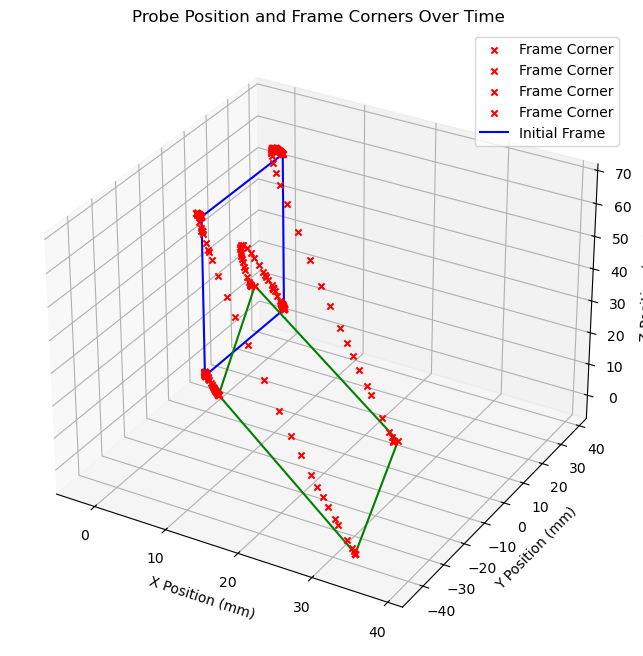

Predicted volume shape: (415, 818, 695)
Volume origin: [ -2.46093835 -43.62158897  -2.50302649]
Voxel size: 0.1 mm
Predicted volume saved as 'predicted_volume.npy'
Metadata saved as 'predicted_volume_metadata.npy'


In [22]:
# Use the trained model to make predictions on the validation set
all_frames = []
all_predictions = []

with torch.no_grad():
    for frames, imu_data, _ in val_loader:
        frames = frames.to(device)
        imu_data = imu_data.to(device)
        outputs = model(frames, imu_data)  # Predicted displacements

        # Append the numpy arrays for frames and predictions
        all_frames.append(frames.cpu().numpy())
        all_predictions.append(outputs.cpu().numpy())

# Concatenate lists into 2D numpy arrays
all_frames = np.concatenate(all_frames, axis=0)
all_predictions = np.concatenate(all_predictions, axis=0)


# Define probe specifications
probe_specs = {
    "depth": 50,  # mm (axial direction)
    "width": 38,  # mm (lateral direction, assuming 19 mm on each side of the center)
    "axial_res": 0.5,  # mm
    "lateral_res": 2,  # mm
    "slice_thickness": 5,  # mm (elevational direction)
    "marker_to_probe_bottom": 54,  # mm (approximate, to be refined)
}

# Reconstruct the predicted volume based on predicted displacements
predicted_volume, volume_origin, voxel_size = reconstruct_predicted_volume_displacement(
    all_frames[:, 0],  # Use only the first frame of each sequence
    all_predictions,  # Use the full prediction array (displacement + angular displacement)
    probe_specs,
    voxel_size=0.1,  # Adjust voxel size for the desired resolution
    initial_pose=None,  # Optionally set initial pose, or keep as None
    ignore_orientation=False,  # Set to False to use predicted orientations
)

print(f"Predicted volume shape: {predicted_volume.shape}")
print(f"Volume origin: {volume_origin}")
print(f"Voxel size: {voxel_size} mm")

# Save the predicted volume
np.save("predicted_volume.npy", predicted_volume)
print("Predicted volume saved as 'predicted_volume.npy'")

# Save metadata
metadata = {
    "volume_origin": volume_origin.tolist(),
    "voxel_size": voxel_size,
    "probe_specs": probe_specs,
}
np.save("predicted_volume_metadata.npy", metadata)
print("Metadata saved as 'predicted_volume_metadata.npy'")

In [ ]:
print(
    f"predicted_frame_centers: {predicted_frame_centers.shape}, ground_truth_centers: {ground_truth_centers.shape}"
)

In [ ]:
def plot_frame_center_trajectories_with_error(
    gt_centers,
    gt_orientations,
    pred_centers,
    pred_orientations,
    frame_stride=1,
    scale=0.2,
):
    """
    Plot ground truth and predicted trajectories of frame centers with orientation vectors and error.

    :param gt_centers: Array of shape (n, 3) with [x, y, z] for each ground truth frame center
    :param gt_orientations: Array of shape (n, 4) with [qw, qx, qy, qz] for each ground truth frame orientation
    :param pred_centers: Array of shape (n, 3) with [x, y, z] for each predicted frame center
    :param pred_orientations: Array of shape (n, 4) with [qw, qx, qy, qz] for each predicted frame orientation
    :param frame_stride: Number of frames to skip between orientation vector plots
    :param scale: Scale factor for orientation vectors
    """
    fig = plt.figure(figsize=(20, 6))

    # Ground Truth Trajectory
    ax1 = fig.add_subplot(131, projection="3d")
    plot_trajectory(
        ax1, gt_centers, gt_orientations, frame_stride, scale, "Ground Truth", "blue"
    )

    # Predicted Trajectory
    ax2 = fig.add_subplot(132, projection="3d")
    plot_trajectory(
        ax2, pred_centers, pred_orientations, frame_stride, scale, "Predicted", "red"
    )

    # Error Plot
    ax3 = fig.add_subplot(133)
    plot_error(ax3, gt_centers, pred_centers)

    plt.tight_layout()
    plt.show()


def plot_trajectory(ax, centers, orientations, frame_stride, scale, title, color):
    ax.plot(
        centers[:, 0], centers[:, 1], centers[:, 2], label="Trajectory", color=color
    )

    for i in range(0, len(centers), frame_stride):
        pos = centers[i]
        quat = orientations[i]
        rot_matrix = Rotation.from_quat(quat).as_matrix()

        axes = np.array([[scale, 0, 0], [0, scale, 0], [0, 0, scale]])
        transformed_axes = rot_matrix @ axes.T + pos[:, np.newaxis]

        colors = ["r", "g", "b"]
        labels = ["X", "Y", "Z"]
        for j, (axis_color, label) in enumerate(zip(colors, labels)):
            ax.quiver(
                pos[0],
                pos[1],
                pos[2],
                transformed_axes[0, j] - pos[0],
                transformed_axes[1, j] - pos[1],
                transformed_axes[2, j] - pos[2],
                color=axis_color,
                label=f"{label} axis" if i == 0 else "",
            )

    ax.set_xlabel("X Position (mm)")
    ax.set_ylabel("Y Position (mm)")
    ax.set_zlabel("Z Position (mm)")
    ax.set_title(f"{title} Frame Center Trajectory")
    ax.legend()


def plot_error(ax, gt_centers, pred_centers):
    error = np.linalg.norm(pred_centers - gt_centers, axis=1)
    ax.plot(error, color="green")
    ax.set_title("Frame Center Position Error Over Time")
    ax.set_xlabel("Frame Index")
    ax.set_ylabel("Position Error (mm)")
    ax.grid(True)


plot_frame_center_trajectories_with_error(
    ground_truth_centers,
    ground_truth_orientations,
    predicted_frame_centers,
    predicted_frame_orientations,
    frame_stride=1,
    scale=0.5,
)